### Swetha Chandrasekar
### Project Alternus verta
### factor: party affliation
Business problem: Party affliation of the news maker is an important factor in deciding the credibility of the news or statement.
It is important to model the factor of Party affliation while fact checking the news.
#### What is party affliation? 
Party refers to an organization, a formal or informal group of like minded members with similar policies and principles and stances on major political issues.
Inferring the Party affliation of a person can help infer the person's stand on major political issues and principles.
Example: 
1. republicans:  leaning right of the political spectrum with support to pro-life, free-market, lesser spending by government. 
2. democrats  leaning left of the political spectrum with explicit suppport to LGBT, relatively more spending by the government by increasing taxes.
<b>Party affliation is not merely confined to the major two. Per LIAR-LIAR dataset, There are 23 different party affliations.</b>
1. tea-party-member(sub wing within the republican party with fiscal conservative policies)
2. talk-show-host
3. state-official 
4. republican
5. organization
6. ocean-state-tea-party-action
7. none
8. newsmaker
9. Moderate
10. libertarian
11. liberal-party-canada
12. labor-leader
13. journalist
14. independent
15. green
16. government-body
17. education-official
18. democratic-farmer-labor
19. democrat
20. constitution-party
21. columnist
22. business-leader
23. activist
<br>
Datasets used: <br>
-1. Getting Real on Fake news Kaggle dataset, <br>
-2. LIAR LIAR dataset,  <br>
-3. million headlines dataset <br>
Pretrained Language model: wikitext-103 (trained using fastai module)
dataset for futher training language model specific to news: million headlines dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

<font color = "green">
    <h1>Approach 1: (LDA + Word2vec, Doc2vec to model party affliation) </h1></font>
<font color= "blue">

<h3>Datasets: 1. million headlines dataset, 2. kaggle fake news dataset for LDA  and 3. LIAR LIAR dataset for modelling the party affliation </h3> </font>
<b>Steps <br>
0. Clean the datasets (standard NLP tokenization, stop word removal, lemmatization & stemming) <br>
1. Perform LDA for distillation on million headlines dataset &  (initial distillation) <br>
2. manually look into  the topics from LDA to create bag of words features and also use word2vec, doc2vec featuers to model the factor of party affliation <br> </b>
<br>=========================================================================================== <br>
<font color = "green">
<h1>Approach 2: (Transfer learning + RNN to model the party affliation)</h1></font>
<font color= "blue">
<h3>Dataset: 1. million headlines dataset for transfer learning and 2. LIAR LIAR dataset for modelling the party affliation
    </h3></font>
  <b>Steps <br>
0. Clean the datasets (standard NLP tokenization, stop word removal, lemmatization & stemming) <br>
1. It is important for the model to understand general english. Start with a pre-trained wikitext RNN based Language model. <br>
2. train an additional layer to produce language model specific to news headlines corpus <br>
3. now train a RNN to predict a softmax score for each of the 23 party affliations <br> </b>

# 1.  LDA on NYTimes articles dataset from Kaggle (initial distillation) 
https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
1. Clean the dataset
    1. Tokenization
    2. Stopwords removal
    3. Lemmatization
    4. Stemming
2. Perform LDA to find N=10 topics 

In [152]:
import pandas as pd
data = pd.read_csv('NYT_headlines.txt', error_bad_lines=False, delimiter='\t');
data_text = data[['headline_text']]
data_text['index'] = data_text.index
documents = data_text
nyt_headlines_dataset = documents.headline_text.tolist()

### Loading gensim and nltk libraries 
### https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24


In [193]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from fastai import *
from fastai.tabular import *
from fastai.text import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [73]:
from nltk import PorterStemmer 
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return text
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result


In [74]:
processed_docs = documents['headline_text'].map(preprocess)
processed_docs[:10]
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

0 expansive
1 finding
2 forgotten
3 niger
4 people
5 view
6 curse
7 dreaded
8 trump
9 descent
10 dictatorship


[(30, 1)]

In [75]:
lda_model1 = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=50, workers=4)


In [76]:
for idx, topic in lda_model1.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.061*"love" + 0.051*"city" + 0.041*"crisis" + 0.039*"american" + 0.035*"battle" + 0.034*"election" + 0.032*"wall" + 0.031*"young" + 0.030*"dies" + 0.030*"vote"
Topic: 1 
Words: 0.382*"trump" + 0.078*"president" + 0.047*"home" + 0.037*"world" + 0.037*"america" + 0.032*"year" + 0.029*"donald" + 0.027*"past" + 0.024*"save" + 0.020*"aide"
Topic: 2 
Words: 0.059*"north" + 0.052*"korea" + 0.052*"right" + 0.048*"race" + 0.047*"student" + 0.038*"heart" + 0.036*"rise" + 0.034*"vietnam" + 0.033*"rules" + 0.025*"anti"
Topic: 3 
Words: 0.060*"good" + 0.056*"black" + 0.054*"help" + 0.037*"years" + 0.036*"variety" + 0.034*"little" + 0.034*"food" + 0.029*"police" + 0.029*"students" + 0.024*"lead"
Topic: 4 
Words: 0.090*"season" + 0.080*"episode" + 0.080*"trade" + 0.054*"house" + 0.036*"going" + 0.034*"recap" + 0.030*"deal" + 0.030*"story" + 0.028*"times" + 0.026*"march"
Topic: 5 
Words: 0.093*"trump" + 0.063*"tariffs" + 0.056*"china" + 0.042*"chief" + 0.040*"fight" + 0.035*"power" +

# 2.  LDA on fake news dataset from Kaggle (initial distillation) 
1. Clean the dataset
    1. Tokenization
    2. Stopwords removal
    3. Lemmatization
    4. Stemming
2. Perform LDA to find N=10 topics 

In [161]:
data = pd.read_csv('fake.csv', error_bad_lines=False);
data_text = data[['title','text']]
data_text['headline_text'] =  data[['title', 'text']].apply(lambda x: ''.join(str(x)).strip().lower().replace('title', '').replace('text',''), axis=1)
data_text = data_text[['headline_text']]
data_text['index'] = data_text.index

documents = data_text
documents.head()
kaggle_fake_news_dataset = data.title.tolist()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Preprocess the document before applying LDA

In [68]:
processed_docs = documents['headline_text'].map(preprocess)
processed_docs[:10]
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

0 busted
1 dtype
2 millions
3 muslims
4 object
5 print
6 stole
7 attorney
8 general
9 loretta
10 lynch


[(867, 3)]

##### Run LDA on fake _news dataset from kaggle

In [70]:
lda_model2 = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=50, workers=4)
for idx, topic in lda_model2.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.071*"october" + 0.050*"america" + 0.027*"gold" + 0.025*"syria" + 0.025*"november" + 0.023*"posted" + 0.023*"report" + 0.021*"state" + 0.019*"policy" + 0.017*"russian"
Topic: 1 
Words: 0.068*"world" + 0.049*"posted" + 0.037*"media" + 0.029*"home" + 0.028*"news" + 0.027*"like" + 0.021*"eddie" + 0.020*"voting" + 0.018*"real" + 0.017*"secret"
Topic: 2 
Words: 0.037*"black" + 0.035*"post" + 0.029*"vote" + 0.026*"john" + 0.025*"comey" + 0.025*"obama" + 0.022*"originally" + 0.021*"published" + 0.021*"email" + 0.020*"states"
Topic: 3 
Words: 0.280*"trump" + 0.065*"donald" + 0.024*"police" + 0.023*"know" + 0.018*"anti" + 0.017*"comments" + 0.014*"going" + 0.013*"email" + 0.013*"dakota" + 0.012*"israel"
Topic: 4 
Words: 0.209*"hillary" + 0.187*"clinton" + 0.049*"email" + 0.028*"campaign" + 0.016*"politics" + 0.013*"leaked" + 0.013*"presidential" + 0.012*"muslim" + 0.011*"investigation" + 0.009*"weiner"
Topic: 5 
Words: 0.097*"november" + 0.037*"putin" + 0.036*"people" + 0.034*

In [293]:
train_path = Path('.')
import pandas as pd
headers = ['id','label','statement','subject',
           'speaker','job_title', 'state', 
           'affliation','barely_true','false',
           'half_true', 'mostly_true','pants_on_fire', 
           'venue']
print (len(headers))
train_df = pd.read_csv('train.tsv', names=headers, delimiter='\t')
valid_df = pd.read_csv('valid.tsv', names=headers, delimiter='\t')
test_df = pd.read_csv('test.tsv',names=headers, delimiter='\t')
train_df['statement'].head()

14


0    Says the Annies List political group supports ...
1    When did the decline of coal start? It started...
2    Hillary Clinton agrees with John McCain "by vo...
3    Health care reform legislation is likely to ma...
4    The economic turnaround started at the end of ...
Name: statement, dtype: object

### Let us prepare training data to generate  custom embeddings word vectors from the following datasets
1. training set of LIAR-LIAR dataset
2. NY times articles
3. fake news kaggle dataset

In [294]:
word_vector_input_dataset = []
word_vector_input_dataset = train_df.statement.tolist() + nyt_headlines_dataset + kaggle_fake_news_dataset

### let us train Doc2vec embeddings


In [295]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
data = word_vector_input_dataset
tagged_data = []
exception_count = 0
for i, _d in enumerate(data):
    try:
        tagged_data.append(TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]))
    except:
        exception_count+=1
### Train doc2vec embeddings 
print ("Total number of custom documents:",len(tagged_data))
max_epochs = 10
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

Total number of custom documents: 31894


/opt/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Model Saved


In [429]:
text = "republican says obama supports third trimester abortion"
dvmodel= Doc2Vec.load("d2v.model")
test_sentence= [dvmodel.infer_vector(word_tokenize(text))]
print (test_sentence)

[array([-0.039492,  0.298048,  0.169804, -0.076881,  0.002514, -0.027018, -0.057517, -0.055   ,  0.042183, -0.076397,
       -0.04792 , -0.177854, -0.246954,  0.104159, -0.094935,  0.113077,  0.452412,  0.039571, -0.183771,  0.074001],
      dtype=float32)]


### let us try to train a multi layer neural network on these embeddings

In [484]:
training_statements = train_df.statement.tolist()
affliation = train_df.affliation.tolist()
validation_statements = valid_df.statement.tolist()
testing_statements = test_df.statement.tolist()
training_statement_wv = []
testing_statement_wv=[]
validation_statement_wv = []
for statement in training_statements:
    training_statement_wv.append(dvmodel.infer_vector(word_tokenize(statement)))
for statement in testing_statements:
    testing_statement_wv.append(dvmodel.infer_vector(word_tokenize(statement)))
for statement in validation_statements:
    validation_statement_wv.append(dvmodel.infer_vector(word_tokenize(statement)))
v_affliation = valid_df.affliation.tolist()
t_affliation = test_df.affliation.tolist()

In [485]:
## Training dataframe
dataframe = pd.DataFrame(training_statement_wv)
dataframe['affliation'] = pd.Series(affliation)
dataframe['state'] = pd.Series(train_df.state)
affliation = {}
affliation['republican'] = 'republican'
affliation['democrat'] = 'democrat'
affliation['none'] ='no_affliation'
getPartyAffliation = lambda x : affliation[str(x).lower()] if x in affliation else 'other'
dataframe['coarse_party_affliation'] = dataframe['affliation'].apply(lambda x: getPartyAffliation(x))
dataframe = dataframe[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,'coarse_party_affliation','state']]
## testing dataframe
test_dataframe = pd.DataFrame(testing_statement_wv)
test_dataframe['affliation']= pd.Series(t_affliation)
test_dataframe['coarse_party_affliation'] = test_dataframe['affliation'].apply(lambda x: getPartyAffliation(x))
test_dataframe['state'] = pd.Series(test_df.state)
test_dataframe = test_dataframe[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,'coarse_party_affliation','state']]


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,coarse_party_affliation,state
1262,0.172824,0.054359,0.179925,-0.163061,-0.379715,-0.338151,0.097224,0.114499,0.077868,0.164311,...,-0.105779,0.095469,-0.245206,0.329054,-0.086412,0.342029,0.082759,0.019836,republican,Florida
1263,0.195295,-0.104173,-0.198341,0.159668,-0.148114,-0.007092,-0.004138,-0.045247,-0.037207,0.040901,...,0.007335,-0.108709,-0.094995,-0.089088,0.086084,0.176751,-0.005063,-0.132539,democrat,Missouri
1264,0.078644,0.225946,0.021954,-0.151033,0.054877,0.509519,-0.386489,0.003629,0.008377,0.011070,...,-0.035126,0.265015,-0.282586,-0.085154,0.092215,-0.218225,-0.070963,0.686584,other,Rhode Island
1265,0.367320,0.175357,-0.238609,0.340504,0.092238,-0.261777,-0.115289,-0.523844,-0.011647,-0.133110,...,-0.170212,-0.047784,0.388599,-0.105632,-0.102104,0.057657,0.224009,-0.239973,republican,Ohio
1266,0.103618,-0.326860,-0.569474,0.068963,-0.320888,0.275103,-0.509008,0.086543,-0.156778,0.394796,...,-0.018164,-0.073232,0.003307,-0.093392,-0.046636,0.160779,0.062954,-0.320199,democrat,NaN


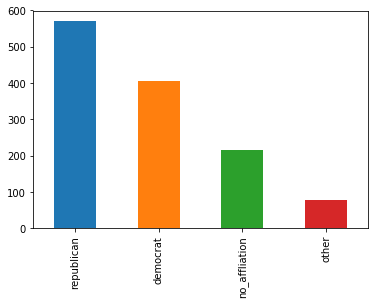

In [476]:
#dataframe.affliation.value_counts().plot(kind='bar')
test_dataframe.coarse_party_affliation.value_counts().plot(kind='bar')#(10)
test_dataframe.tail()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,coarse_party_affliation,state
0,-0.143619,-0.216212,-0.290813,0.051276,-0.223865,-0.371174,0.069065,0.132465,-0.230092,0.101802,...,0.004405,-0.427460,-0.066267,0.143366,-0.106228,0.066536,0.140502,-0.370254,republican,Texas
1,-0.053220,0.309012,0.146535,0.027153,-0.033411,-0.058263,0.178007,-0.117220,0.224724,0.498460,...,0.148538,-0.078412,0.277723,-0.096966,-0.559023,-0.300156,0.437579,-0.090232,democrat,Virginia
2,-0.073802,0.159426,-0.404452,-0.197545,-0.168435,-0.217475,-0.080099,-0.120278,-0.074218,0.182147,...,0.136587,-0.392777,0.056764,-0.198190,-0.323156,-0.499402,0.486976,-0.251353,democrat,Illinois
3,0.088686,-0.032666,-0.133462,0.050155,-0.048437,-0.176704,-0.105346,-0.018063,-0.010706,-0.040651,...,-0.196485,0.064489,-0.113267,-0.160550,-0.034638,0.033173,0.084144,0.173827,no_affliation,NaN
4,-0.064359,-0.000891,-0.404637,0.198261,-0.232511,-0.247655,0.046283,-0.016482,-0.120002,0.242610,...,-0.119005,-0.335411,0.075146,0.082305,-0.158520,-0.054074,0.090555,-0.295901,democrat,Florida


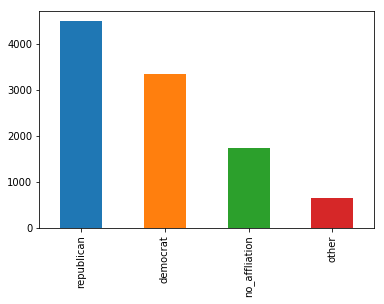

In [490]:
dataframe.coarse_party_affliation.value_counts().plot(kind='bar')
dataframe.head()

print("hi")

In [491]:
X = pd.concat([test_dataframe,dataframe])
X.columns = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','coarse_party_affliation','state']
print(len(X))
print(len(dataframe))
print(len(test_dataframe))
test_dataframe.head()

cat_names= []
cont_names = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19']

test = TabularList.from_df(X.iloc[0:1267].copy(), path=path, cat_names=cat_names, cont_names=cont_names)
X.head()

11507
10240
1267


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,coarse_party_affliation,state
0,0.028429,0.089552,0.155846,-0.153375,-0.174918,-0.038579,-0.020687,0.077130,-0.053375,0.283203,...,0.082695,0.155945,-0.068309,0.025655,-0.146420,0.031431,-0.202433,-0.050921,republican,Texas
1,0.158467,-0.071286,-0.028012,0.132037,-0.172780,-0.381861,0.108267,0.051249,-0.107917,-0.050178,...,0.129857,-0.371630,-0.163643,0.255207,-0.006722,0.116628,0.204690,-0.336670,democrat,Wisconsin
2,0.108558,-0.017118,0.003803,0.121097,0.090083,-0.007859,-0.019869,-0.018345,-0.136598,-0.023510,...,0.110063,-0.151571,-0.062186,-0.095369,-0.007899,0.088482,0.089172,0.160237,republican,New York
3,-0.120239,0.073868,-0.026789,-0.145718,-0.174701,-0.099545,-0.134129,0.075555,-0.108814,0.319961,...,0.004666,-0.154166,0.034104,-0.094976,-0.430535,0.039017,0.063961,0.020885,republican,Oregon
4,-0.269898,0.034153,0.180928,-0.057968,-0.241570,0.141744,-0.049819,-0.167029,0.182577,0.098084,...,0.103190,-0.084038,-0.078877,0.114770,-0.182745,-0.205095,-0.157053,-0.005502,democrat,Wisconsin


In [492]:
path = Path()
procs = [FillMissing, Categorify, Normalize]
dep_var = 'coarse_party_affliation'
valid_idx = list(range(0,1267))
DB = (TabularList.from_df(X, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
      .split_by_idx(valid_idx)
      .label_from_df(cols=dep_var)
      .add_test(test, label=0)
      .databunch())
DB.show_batch(rows=10)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,target
1.7425,-0.2389,0.2362,-0.0345,-0.0581,0.5292,-0.6711,-0.8612,1.0757,0.8215,0.0720,0.4299,0.4103,1.1239,-0.4190,0.0042,-0.3432,-2.3358,0.9549,0.3615,republican
-0.3851,0.0941,-0.2017,-0.5467,0.2397,0.4327,0.2075,0.2148,0.0361,-0.8497,0.1395,0.1568,-0.9811,0.6486,-0.3371,0.3185,0.8133,0.4175,-0.5050,1.4286,republican
-0.4938,-0.5662,-0.2258,0.2300,-0.5408,-0.6669,0.7639,-0.3717,-0.1568,-0.0758,-0.6313,1.3683,-0.1194,-1.0069,0.1039,-0.3609,-0.7338,0.5241,0.7788,-0.0032,no_affliation
-0.4930,-1.2710,1.0198,-2.4201,0.6270,0.1588,-0.0570,2.0261,1.3075,-1.2070,-0.9349,-1.9268,0.7115,0.7828,-1.7827,-0.1797,1.4189,1.8294,-0.7857,1.2868,other
1.0307,-0.1590,-0.9578,1.7527,0.1500,-0.8598,0.4379,-0.8106,-0.8540,0.8592,-1.0316,-0.1719,-0.1835,-1.4949,1.1454,1.1383,-1.3550,-0.3428,0.8741,-2.5020,republican
0.0924,1.5111,1.0163,-0.8371,0.9369,0.7672,-0.3469,-0.3013,0.6025,-0.7010,-0.2760,-0.2480,-0.4730,1.3077,0.7851,-0.6095,1.9627,-0.3196,-0.0962,0.5085,no_affliation
-0.2042,-1.7039,-1.2361,1.0923,-0.2171,-0.9514,1.3384,0.6193,-1.8660,-0.8468,0.0573,1.1892,-0.0284,-1.5595,-0.5073,0.7192,0.5077,1.5749,-0.9226,-1.6650,democrat
-0.2742,0.2085,0.7861,0.1291,0.3495,2.1721,-0.2908,0.6035,0.5035,-1.1085,-0.9437,-0.2433,-0.0309,1.1441,-0.0647,0.3354,0.7054,-1.5033,-0.4617,0.7291,republican
-1.8321,0.6258,0.0162,-0.0666,1.0612,-1.0907,1.0733,0.2132,-0.6077,0.0202,0.3230,-0.6274,-0.5067,-0.2438,0.1230,-0.4688,0.4084,0.8951,-0.4759,-0.7933,democrat
1.3555,0.1695,-0.8096,1.1807,-0.2602,-2.3802,1.0714,0.0955,-1.0978,-0.1432,1.7183,-0.2404,-0.2794,-1.0357,-0.0311,0.9088,1.4977,2.3811,-0.9551,-0.2146,other


In [532]:
learn = tabular_learner(DB, layers=[20,10,4], metrics=accuracy,emb_drop=0.2)
??tabular_learner

In [533]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.2)
  (bn_cont): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=20, out_features=10, bias=True)
    (4): ReLU(inplace)
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=10, out_features=4, bias=True)
    (7): ReLU(inplace)
    (8): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=4, out_features=4, bias=True)
  )
)

In [534]:
learn.fit(6,1e-5)


Total time: 00:11
epoch  train_loss  valid_loss  accuracy
1      1.488690    1.520222    0.217837  (00:01)
2      1.482500    1.520639    0.223362  (00:01)
3      1.475947    1.521153    0.220994  (00:01)
4      1.482888    1.519387    0.221784  (00:01)
5      1.481273    1.516523    0.224152  (00:01)
6      1.481591    1.508934    0.229676  (00:01)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


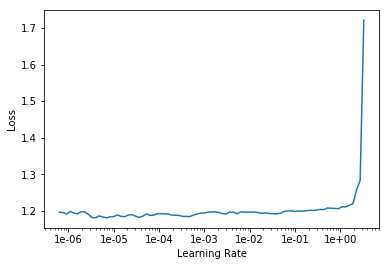

In [503]:
learn.lr_find()
learn.recorder.plot()
learn.save("NN_model_to_predict_political_Affliation")

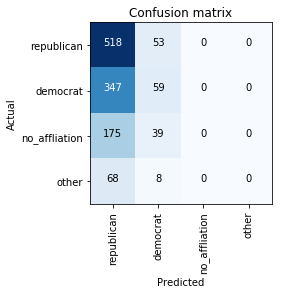

In [504]:
from fastai import *
from fastai.vision import *
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [ ]:
learn.le

### Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [22]:
data = TextClasDataBunch.load(path)
data.show_batch()

text,label
"xxbos xxfld 1 raising victor vargas : a review \n\n you know , raising victor vargas is like sticking your hands into a big , xxunk bowl of xxunk . it 's warm and gooey , but you 're not sure if it feels right . try as i might",negative
"xxbos xxfld 1 now that che(2008 ) has finished its relatively short australian cinema run ( extremely limited xxunk screen in xxunk , after xxunk ) , i can xxunk join both xxunk of "" at the movies "" in taking steven soderbergh to task . \n\n it 's usually",negative
"xxbos xxfld 1 many xxunk that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . it 's also one of the first xxunk games , one of the xxunk definitely the first",positive
"xxbos xxfld 1 i really wanted to love this show . i truly , honestly did . \n\n for the first time , gay viewers get their own version of the "" the bachelor "" . with the help of his obligatory "" hag "" xxunk , james , a",negative
xxbos xxfld 1 this film sat on my xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the xxunk - up xxunk of new xxunk . \n\n the,positive


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like his: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [23]:
data.vocab.itos[:10]

['xxunk', 'xxpad', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [24]:
data.train_ds[0]

(Text xxbos xxfld 1 he now has a name , an identity , some memories and a a lost girlfriend . all he wanted was to disappear , but still , they xxunk him and destroyed the world he hardly built . now he wants some explanation , and to get ride of the people how made him what he is . yeah , jason bourne is back , and this time , he 's here with a vengeance . 
 
  xxup ok , this movie does n't have the most xxunk script in the world , but its thematics are very clever and ask some serious questions about our society . of course , like every xxunk movie since the end of the 90 's , " the bourne xxunk " is a super - heroes story . jason bourne is a captain - america project - like , who 's gone completely wrong . in the first movie , the hero discovered his abilities and he accepted them in the second one . he now fights against what he considers like evil , after a person close to him has been killed ( his girlfriend in " xxunk " ) by them . that 's all a part of the super - hero story , 

But the underlying data is all numbers

In [26]:
data.train_ds[0][0].data[:10]
type(data)

fastai.text.data.TextClasDataBunch

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [28]:
data1 = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())
print (path)

/home/jupyter/.fastai/data/imdb_sample


Now let's grab the full dataset for what follows.

In [29]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/models'),
 PosixPath('/home/jupyter/.fastai/data/imdb/test'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train'),
 PosixPath('/home/jupyter/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/jupyter/.fastai/data/imdb/README'),
 PosixPath('/home/jupyter/.fastai/data/imdb/tmp_lm')]

In [30]:
(path/'train').ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/train/unsup'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/pos'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/neg')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder in `train` that contains the unlabelled data.

## Language model

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviex lefts by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [31]:
print(path)
bs=48

/home/jupyter/.fastai/data/imdb


This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [32]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('tmp_lm')

data = TextList.from_csv(

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [33]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [ ]:
data_lm.show_batch()

idx,text
0,"xxbos after seeing the truman show , i wanted to see the other films by weir . i would say this is a good one to start with . the plot : \n\n the wife of a doctor ( who is trying to impress his bosses , so he can get xxunk trying to finish her written course , while he s at work . but one day a strange man , who says that he s a plumber , tells her he s been called out to repair some pipes in there flat ."
1,"and turn to the wisdom of homeless people & ghosts . that 's a good plan . i would never recommend this movie ; partly because the sexual content is unnecessarily graphic , but also because it really does n't offer any valuable insight . check out "" yentl "" if you want to see a much more useful treatment of jewish tradition at odds with society . xxbos creep is the story of kate ( potente ) , an intensely unlikeable bourgeois bitch that finds herself somehow sleeping through the noise of the last"
2,"been done before but there is something about the way its done here that lifts it up from the rest of the pack . \n\n 8 out of 10 for dinosaur / monster lovers . xxbos i rented this movie to see how the sony xxunk camera shoots , ( i recently purchased the same camera ) and was blown away by the story and the acting . the directing , acting , editing was all above what i expected from what appeared at first glance to be a "" low budget "" type of"
3,"troubles . nigel and xxunk are the perfect team , i 'd watch their show any day ! i was so crushed when they removed it , and anytime they had it on xxup tv after that i was over the moon ! they put it on on demand one summer ( only the first eight episodes or so ) and i 'd spend whole afternoons watching them one after the other ... but the worst part ? it is now back on a channel called xxunk - and xxup it xxup 's xxup on"
4,"movie ! ) the movie is about edward , a obsessive - compulsive , nice guy , who happens to be a film editor . he is then lent to another department in the building , and he is sent to the posh yet violent world of sam campbell , the splatter and gore department . sam campbell , eddy 's new boss , is telling eddy about the big break on his movies , the gruesome loose limbs series , and he needs eddy to make the movie somewhat less violent so they can"
5,"incredible action ( especially the finale featuring an excellent dragon ) and a generally brilliant cast . beowulf throws down the gauntlet to film - makers to show what can be done with xxup 3d and is an indication of the potential . it 's not all the way there yet , but it 's a damn good start . xxbos freeman gives his most powerful performance here . i 've seen almost all of morgan 's films but i think this is his most outstanding performance . fast black is one juicy character and"
6,"his terms . a better title for the film would be "" it came from the planet of plot contrivances . "" the plot is excessively silly and nearly nonexistent . the humans are all given magical macguffins that conform to a tortuous series of unlikely restrictions just to move the bare plot . any thought to the passage of time is ignored . now it 's a couple days after meeting the alien , then xxup bam ! all of a sudden there 's only a couple hours left until zero hour . do"
7,"do n't know who 's the hero or who 's the villian because everyone is so stupid that no one even cares . there is only one scene in this movie that 's good , where the nerd is trying to impress a girl and gets onto his motor powered trashy bike and crashed into a wall ! the nerd does try to be funny at times ( in a freddy krueger type of way ) but notice i say "" try "" . the music is tasteless , and so is the script ."
8,", to talk or to make lots of thing ! my conclusion is that this movie is not funny in a good way , but in a really stupid way ! xxbos just saw coronado ... around here the only line they came up with to sell it is "" from the xxup fx team behind independence day "" . i think that says a great deal . no talk about writers 

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in './fastai/models/' (or elsewhere if you specified different paths in your config file).

In [ ]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.3)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


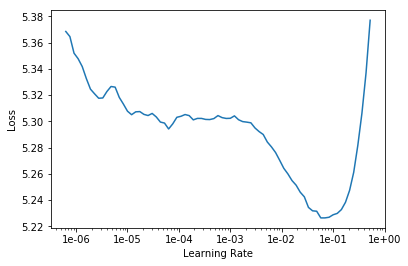

In [ ]:
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

Total time: 12:42
epoch  train_loss  valid_loss  accuracy
1      4.591534    4.429290    0.251909  (12:42)



In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

Total time: 2:22:17
epoch  train_loss  valid_loss  accuracy
1      4.307920    4.245430    0.271067  (14:14)
2      4.253745    4.162714    0.281017  (14:13)
3      4.166390    4.114120    0.287092  (14:14)
4      4.099329    4.068735    0.292060  (14:10)
5      4.048801    4.035339    0.295645  (14:12)
6      3.980410    4.009860    0.298551  (14:12)
7      3.947437    3.991286    0.300850  (14:14)
8      3.897383    3.977569    0.302463  (14:15)
9      3.866736    3.972447    0.303147  (14:14)
10     3.847952    3.972852    0.303105  (14:15)



In [ ]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned');

In [ ]:
learn.predict('I liked this movie because ', 100, temperature=1.1, min_p=0.001)

Total time: 00:10



'I liked this movie because  of course after yeah funny later that the world reason settings - the movie that perfect the kill of the same plot - a mention of the most of course . do xxup diamonds and the " xxup disappeared kill of course and the movie niece , from the care more the story of the let character , " i was a lot \'s the little performance is not only . the excellent for the most of course , with the minutes night on the into movies ( ! , in the movie its the first ever ! \n\n a'

We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [ ]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/jhoward/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/jhoward/.fastai/data/imdb/models'),
 PosixPath('/home/jhoward/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train'),
 PosixPath('/home/jhoward/.fastai/data/imdb/test'),
 PosixPath('/home/jhoward/.fastai/data/imdb/README'),
 PosixPath('/home/jhoward/.fastai/data/imdb/tmp_clas')]

In [ ]:
(path/'train').ls()

[PosixPath('/home/jhoward/.fastai/data/imdb/train/pos'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/unsup'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/neg')]

In [81]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #remove docs with labels not in above list (i.e. 'unsup')
             .filter_missing_y()
             #label them all with their folders
             .databunch(bs=bs))
data_clas.save('tmp_clas')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
len(data_clas.train_ds)

75000

In [ ]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=bs)
data_clas.show_batch()

text,label
"xxfld 1 match 1 : tag team table match bubba ray and spike dudley vs eddie guerrero and chris benoit bubba ray and spike dudley started things off with a tag team table match against eddie guerrero and chris benoit . according to the rules of the match , both",pos
"xxfld 1 i have never seen any of spike lee 's prior films , as their trailers never caught my interest . i have seen , and admire denzel washington , and jodie foster 's work , and have several of their dvds . i was , however , entirely",neg
"xxfld 1 pier paolo pasolini , or pee - pee - pee as i prefer to call him ( due to his love of showing male genitals ) , is perhaps xxup the most overrated european marxist director - and they are thick on the ground . how anyone can",neg
"xxfld 1 chris rock deserves better than he gives himself in "" down to earth . "" as directed by brothers chris & paul weitz of "" american pie "" fame , this uninspired remake of warren beatty 's 1978 fantasy "" heaven can wait , "" itself a rehash",neg
"xxfld 1 yesterday , i went to the monthly antique flea market that comes to town . i really have no interest in such things , but i went for the fellowship of friends who do have such an interest . looking over the hundreds of vendor , passing many",pos


We can then create a model to classify those reviews and load the encoder we saved before.

In [80]:
#learn = text_classifier_learner(data_clas, drop_mult=0.5)
#learn.load_encoder('fine_tuned_enc')
#learn.freeze()
??text_classifier_learner

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


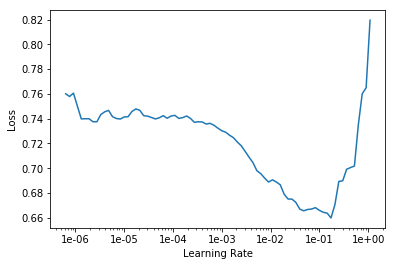

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

Total time: 02:46
epoch  train_loss  valid_loss  accuracy
1      0.294225    0.210385    0.918960  (02:46)



In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

Total time: 03:03
epoch  train_loss  valid_loss  accuracy
1      0.268781    0.180993    0.930760  (03:03)



In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

Total time: 04:06
epoch  train_loss  valid_loss  accuracy
1      0.211133    0.161494    0.941280  (04:06)



In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

Total time: 10:01
epoch  train_loss  valid_loss  accuracy
1      0.188145    0.155038    0.942480  (05:00)
2      0.159475    0.153531    0.944040  (05:01)



In [ ]:
learn.predict("I really loved that movie, it was awesome!")

('pos', tensor(0), tensor([[9.9999e-01, 1.1991e-05]]))